# 地方競馬（NAR）スピード指数分析

この遂次、`NarFeatureGenerator` に実装されたスピード指数の有効性を検証します。
基準タイム（同一場・距離・馬場状態の過去中央値）との差分をベースにした指数の分布と、将来の着順予測への寄与度を確認します。

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

# プロジェクトのsrcディレクトリをパスに追加
src_path = os.path.abspath(os.path.join(os.getcwd(), '../../src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from nar.loader import NarDataLoader
from nar.features import NarFeatureGenerator

%matplotlib inline
sns.set(font="IPAexGothic", style="whitegrid")

## 1. データのロードと特徴量生成

南関東のデータを読み込み、スピード指数を計算します。

In [2]:
loader = NarDataLoader()
raw_df = loader.load(limit=100000, region='south_kanto')
feature_gen = NarFeatureGenerator(history_windows=[1, 3, 5])
df = feature_gen.generate_features(raw_df)
print(f"データ件数: {len(df)}")

重複データを削除しました: 100000 -> 98004 件


データ件数: 25721


## 2. スピード指数の分布確認

算出されたスピード指数が期待通り 80 前後に分布しているか、外れ値がないかを確認します。

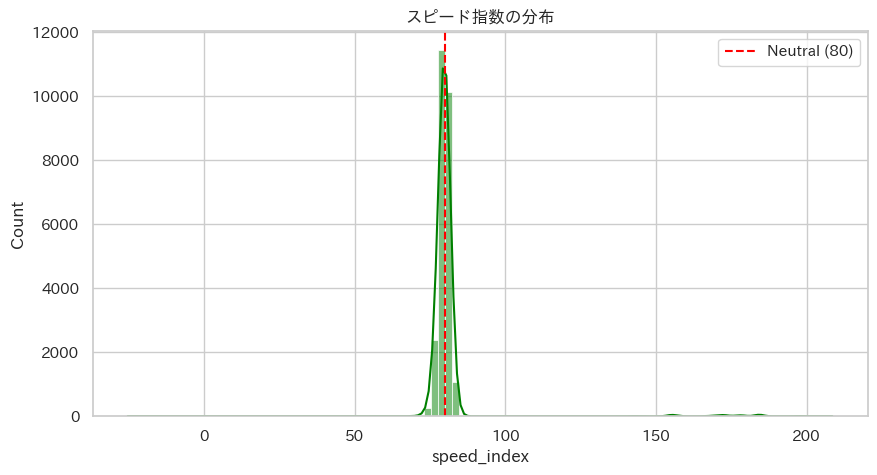

スピード指数の基本統計量:


count    25721.000000
mean        80.756141
std         10.596427
min        -25.300000
25%         78.600000
50%         79.700000
75%         80.800000
max        208.500000
Name: speed_index, dtype: float64

In [3]:
plt.figure(figsize=(10, 5))
sns.histplot(df['speed_index'], bins=100, kde=True, color='green')
plt.title("スピード指数の分布")
plt.axvline(80, color='red', linestyle='--', label='Neutral (80)')
plt.legend()
plt.show()

print("スピード指数の基本統計量:")
display(df['speed_index'].describe())

## 3. 過去指数との相関分析

「前走のスピード指数」や「過去3戦平均スピード指数」が、今走の着順とどの程度相関しているかを可視化します。

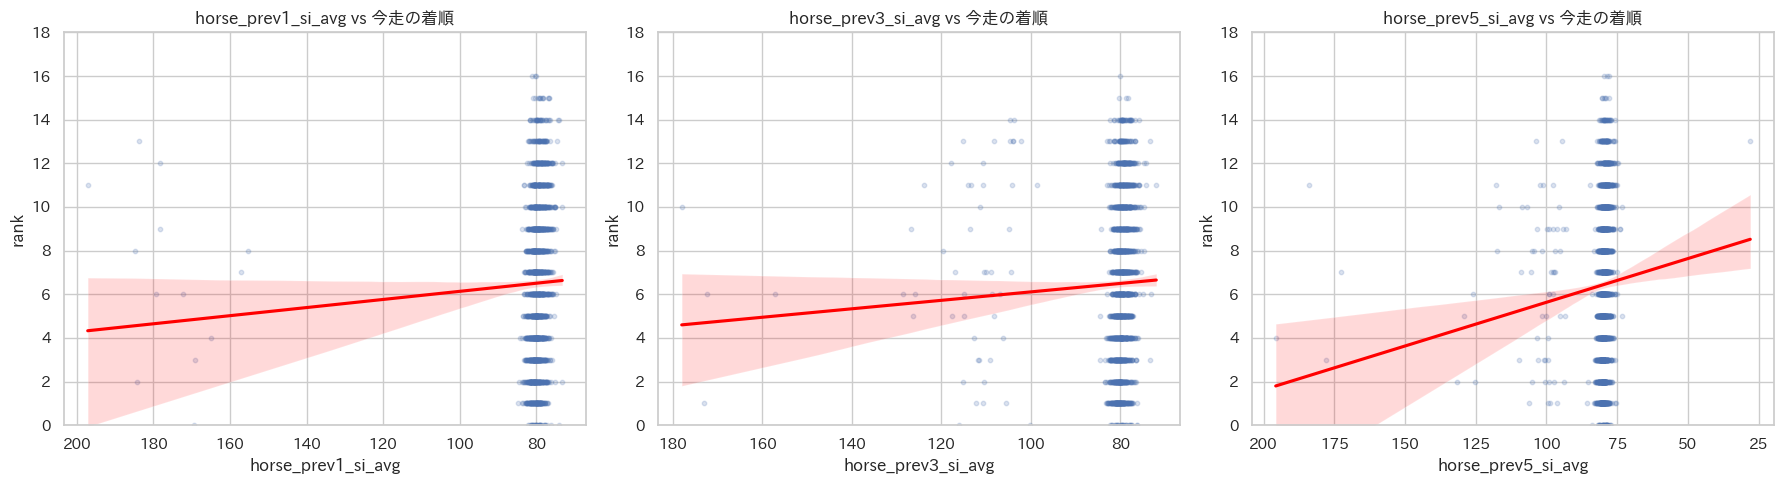

相関係数 (着順との相関):
horse_prev5_si_avg   -0.057029
horse_prev3_si_avg   -0.051962
horse_prev1_si_avg   -0.035341
rank                  1.000000
Name: rank, dtype: float64


In [4]:
si_cols = ['horse_prev1_si_avg', 'horse_prev3_si_avg', 'horse_prev5_si_avg']
valid_df = df.dropna(subset=['horse_prev3_si_avg'])

plt.figure(figsize=(18, 5))
for i, col in enumerate(si_cols):
    plt.subplot(1, 3, i+1)
    sns.regplot(data=valid_df.sample(min(2000, len(valid_df))), x=col, y='rank', 
                scatter_kws={'alpha':0.2, 's':10}, line_kws={'color':'red'})
    plt.title(f"{col} vs 今走の着順")
    plt.ylim(0, 18)
    plt.gca().invert_xaxis() # 指数は高いほど良いため反転

plt.tight_layout()
plt.show()

print("相関係数 (着順との相関):")
print(df[['rank'] + si_cols].corr()['rank'].sort_values())

## 4. 走破タイム vs スピード指数の関係

同一距離でのタイムと指数がどのように関係しているか（基準タイムによる正規化の効果）を確認します。

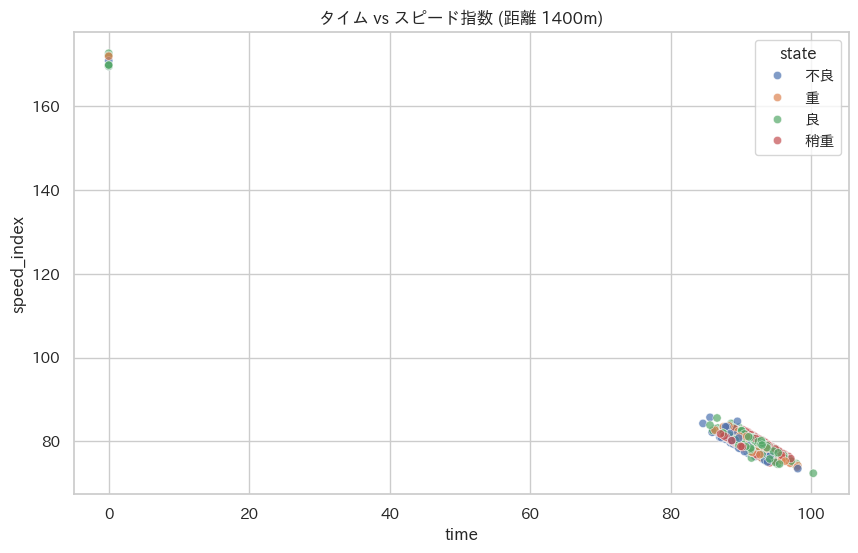

In [5]:
example_df = df[df['distance'] == 1400].sample(min(1000, len(df[df['distance'] == 1400])))
plt.figure(figsize=(10, 6))
sns.scatterplot(data=example_df, x='time', y='speed_index', hue='state', alpha=0.7)
plt.title("タイム vs スピード指数 (距離 1400m)")
plt.grid(True)
plt.show()